# 타이타닉 생존 예측 경진대회
- https://dacon.io/competitions/open/235539/overview/description
- 목표: 주어진 데이터를 바탕으로 타이타닉 생존을 예측

# 패키지 Import

In [1]:
import numpy as np
import pandas as pd

# 데이터 불러오기

In [5]:
df_tit = pd.read_csv('train.csv')
df_test = pd.read_csv("test.csv", index_col=0)
df_tit.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# EDA
- 데이터의 열별 정보 확인
- 변수 간 상관관계 확인
- 변수별 분포 확인

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

#경고 메시지 숨기기
import warnings
warnings.filterwarnings(action='ignore')

In [6]:
df_tit.info(), df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 

(None, None)

PassengerID : 탑승객 고유 아이디

Survival : 탑승객 생존 유무 (0: 사망, 1: 생존)

Pclass : 등실의 등급

Name : 이름

Sex : 성별

Age : 나이

Sibsp : 함께 탐승한 형제자매, 아내, 남편의 수

Parch : 함께 탐승한 부모, 자식의 수

Ticket :티켓 번호

Fare : 티켓의 요금

Cabin : 객실번호

Embarked : 배에 탑승한 항구 이름 ( C = Cherbourn, Q = Queenstown, S = Southampton)


#### - train 데이터에는 Age, Cabin, Embarked에 결측치 존재
#### - test 데이터에는 Age, Fare, Cabin에 결측치 존재

<AxesSubplot:>

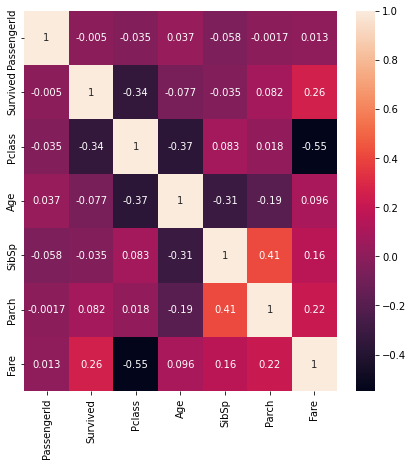

In [ ]:
# 상관계수 시각화
plt.figure(figsize=(7, 7))
sns.heatmap(data=df_tit.corr(), annot=True)

#### - Survived와 ``Pclass``의 상관계수가 -0.34로 약간의 음의 상관관계
#### - Survived와 ``Fare``의 상관계수가 0.26으로 아주 약간의 양의 상관관계

In [ ]:
df_tit.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

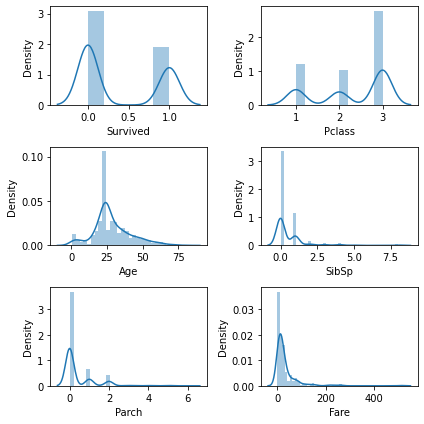

In [ ]:
# 각 칼럼별 분포 확인

#숫자형이 아닌 것과 의미 없을 것 같은 PassengerId 제외
df_tit_num = df_tit[['Survived','Pclass','Age','SibSp','Parch','Fare']]

plt.figure(figsize=(6, 6))
for i in range(6):
    plt.subplot(3, 2, i+1)
    sns.distplot(df_tit_num.iloc[:, i])
plt.tight_layout()
plt.show()

<AxesSubplot:ylabel='Sex'>

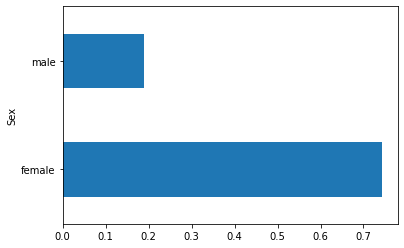

In [ ]:
#성별 생존율
df_tit.groupby(['Sex'])['Survived'].mean().plot(kind='barh')

#### 남성보다 여성이 훨씬 많이 살아남았음을 알 수 있다.

<AxesSubplot:ylabel='Pclass'>

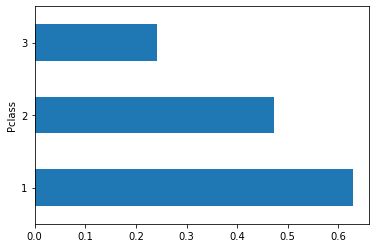

In [ ]:
#등실등급
df_tit.groupby(['Pclass'])['Survived'].mean().plot(kind='barh')

#### 1등석이 제일 많이 살아남았다.

<AxesSubplot:ylabel='Embarked'>

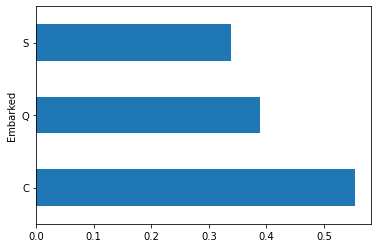

In [ ]:
#승선항
df_tit.groupby(['Embarked'])['Survived'].mean().plot(kind='barh')

#### c항에서 탑승한 사람들이 더 많이 생존하였다. 

# 데이터 전처리
1. NAN 값 처리
2. Sipsp와 Parch 가족수로 통합
3. Scaler
4. 범주형 변수 처리

## 1. NAN 값 처리
- train, test 데이터에서 cabin은 결측치 값이 너무 방대하여 처리에서 제외
- train, test의 Age 처리
- train의 Embarked 처리
- test의 Fare 처리

In [7]:
#train 데이터의 결측치 개수
#Age, Cabin, Embarked에 결측치 존재
print(df_tit.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [8]:
#test 데이터의 결측치 개수
#Age, Fare, Cabin에 결측치 존재
print(df_test.isnull().sum())

Pclass        0
Name          0
Sex           0
Age          86
SibSp         0
Parch         0
Ticket        0
Fare          1
Cabin       327
Embarked      0
dtype: int64


### 나이
- 이름의 이니셜을 추출해 각 이니셜별 나이 평균을 구하여 결측치를 채워줌

In [9]:
df_tit['Initial']=0
for i in df_tit:
    df_tit['Initial']=df_tit.Name.str.extract('([A-Za-z]+)\.')

In [ ]:
df_tit['Initial']

0        Mr
1       Mrs
2      Miss
3       Mrs
4        Mr
       ... 
886     Rev
887    Miss
888    Miss
889      Mr
890      Mr
Name: Initial, Length: 891, dtype: object

In [11]:
df_test['Initial'] = 0
for i in df_test:
    df_test['Initial'] = df_test.Name.str.extract('([A-Za-z]+)\.')
df_test['Initial']

PassengerId
892         Mr
893        Mrs
894         Mr
895         Mr
896        Mrs
         ...  
1305        Mr
1306      Dona
1307        Mr
1308        Mr
1309    Master
Name: Initial, Length: 418, dtype: object

In [ ]:
df_tit.groupby('Initial')['Survived'].count().sort_values(ascending=False)

Initial
Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Major         2
Col           2
Mlle          2
Mme           1
Ms            1
Capt          1
Lady          1
Jonkheer      1
Don           1
Countess      1
Sir           1
Name: Survived, dtype: int64

In [12]:
df_tit['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don'],['Miss','Miss','Miss','Mr','Mrs','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr'], inplace = True)
df_test['Initial'].replace(['Rev','Col','Dr','Dona','Ms'],['Other','Other','Mr','Mr',"Miss"],inplace=True)

In [ ]:
df_tit.groupby('Initial')['Age'].mean() #이니셜별 나이의 평균

Initial
Master     6.516750
Miss      22.274194
Mr        30.689753
Mrs       34.596899
Other     45.888889
Name: Age, dtype: float64

In [13]:
#결측치 채우기
df_tit.loc[(df_tit.Age.isnull())&(df_tit.Initial=='Mr'),'Age']=31
df_tit.loc[(df_tit.Age.isnull())&(df_tit.Initial=='Mrs'),'Age']=35
df_tit.loc[(df_tit.Age.isnull())&(df_tit.Initial=='Master'),'Age']=7
df_tit.loc[(df_tit.Age.isnull())&(df_tit.Initial=='Miss'),'Age']=22
df_tit.loc[(df_tit.Age.isnull())&(df_tit.Initial=='Other'),'Age']=46

df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Mr'),'Age']=31
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Mrs'),'Age']=35
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Master'),'Age']=7
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Miss'),'Age']=22
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Other'),'Age']=46

In [14]:
#결측치 없음을 확인
print(df_tit['Age'].isnull().sum())
print(df_test['Age'].isnull().sum())

0
0


### 승선항
- 결측치가 2개 뿐이라 최빈값을 넣어줌

In [15]:
df_tit['Embarked'] = df_tit['Embarked'].fillna('S') #최빈값인 S로 채워줌

#결측치 개수
print(df_tit['Embarked'].isnull().sum())

0


### 요금
- 평균으로 결측치를 채움

In [18]:
from sklearn.impute import SimpleImputer
simple_imp = SimpleImputer(strategy="mean") #평균으로 채워줌
values = simple_imp.fit_transform(df_test[["Fare"]])
df_test['Fare'] = values

#결측치 개수
print(df_tit['Fare'].isnull().sum())

0


## 2. Sibsp와 Parch 가족수로 통합

In [97]:
df_tit['member'] = df_tit['Parch'] + df_tit['SibSp']  # 가족수 열 추가
df_tit = df_tit.drop(['Parch','SibSp'],axis = 1) # Parch, SibSp 열 삭제

In [99]:
df_tit.head(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,Initial,EM_C,EM_Q,EM_S,member
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,A/5 21171,7.25,NaN,S,Mr,0.0,0.0,1.0,1


In [159]:
df_test['member'] = df_test['Parch'] + df_test['SibSp']  # 가족수 열 추가
df_test = df_test.drop(['Parch','SibSp'],axis = 1) # Parch, SibSp 열 삭제

## 3. Scaler

In [19]:
from sklearn.preprocessing import StandardScaler

In [101]:
df_tit.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'Ticket',
       'Fare', 'Cabin', 'Embarked', 'Initial', 'EM_C', 'EM_Q', 'EM_S',
       'member'],
      dtype='object')

In [100]:
sds = StandardScaler()

# 종속변수 제외, test파일과 맞춰주기 위해 PassengerId 제외
numeric_columns = ['Pclass','Age','member','Fare']

df_tit_norm = sds.fit_transform(df_tit[numeric_columns])

In [102]:
df_tit_norm.shape

(891, 4)

## 4. 범주형 변수 처리

In [103]:
from sklearn.preprocessing import LabelEncoder

In [31]:
from sklearn.preprocessing import OneHotEncoder

### 성별

In [ ]:
df_tit['Sex'].unique()

array(['male', 'female'], dtype=object)

In [80]:
enc = LabelEncoder()

In [ ]:
enc.fit_transform(df_tit['Sex']).shape #일차원

(891,)

In [ ]:
enc.fit_transform(df_tit['Sex']).reshape(-1, 1).shape #이차원

(891, 1)

In [ ]:
enc.fit_transform(df_tit['Sex']).reshape(-1, 1)

In [104]:
#hstack은 가로로 결합. 배열 행이 일치해야 하므로 reshape를 행함.
train_data = np.hstack([df_tit_norm, enc.fit_transform(df_tit['Sex']).reshape(-1, 1)])

In [105]:
train_data.shape

(891, 5)

In [106]:
train_data

array([[ 0.82737724, -0.57278998,  0.05915988, -0.50244517,  1.        ],
       [-1.56610693,  0.63906634,  0.05915988,  0.78684529,  0.        ],
       [ 0.82737724, -0.2698259 , -0.56097483, -0.48885426,  0.        ],
       ...,
       [ 0.82737724, -0.57278998,  1.29942929, -0.17626324,  0.        ],
       [-1.56610693, -0.2698259 , -0.56097483, -0.04438104,  1.        ],
       [ 0.82737724,  0.18462022, -0.56097483, -0.49237783,  1.        ]])

### 승선항

In [30]:
df_tit['Embarked'].unique()

array(['S', 'C', 'Q'], dtype=object)

In [32]:
onehot_encoder = OneHotEncoder()

In [35]:
encoded_em = onehot_encoder.fit_transform(df_tit['Embarked'].values.reshape(-1,1)) 

In [85]:
onehot_encoder.categories_

[array(['C', 'Q', 'S'], dtype=object)]

In [38]:
onehot_encoder.categories_[0]

array(['C', 'Q', 'S'], dtype=object)

In [39]:
encoded_em.toarray()

array([[0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.]])

In [40]:
# EM_S, EM_C, EM_Q로 칼럼을 만든다.
em_columns = ['EM_' + em for em in onehot_encoder.categories_[0]]

# 만든 칼럼에 각 데이터를 추가
df_tit[em_columns] = encoded_em.toarray()

In [107]:
df_tit

,PassengerId,Survived,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,Initial,EM_C,EM_Q,EM_S,member
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,A/5 21171,7.2500,NaN,S,Mr,0.0,0.0,1.0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,PC 17599,71.2833,C85,C,Mrs,1.0,0.0,0.0,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,STON/O2. 3101282,7.9250,NaN,S,Miss,0.0,0.0,1.0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,113803,53.1000,C123,S,Mrs,0.0,0.0,1.0,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,373450,8.0500,NaN,S,Mr,0.0,0.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,211536,13.0000,NaN,S,Other,0.0,0.0,1.0,0
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,112053,30.0000,B42,S,Miss,0.0,0.0,1.0,0
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,22.0,W./C. 6607,23.4500,NaN,S,Miss,0.0,0.0,1.0,3
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,111369,30.0000,C148,C,Mr,1.0,0.0,0.0,0


In [108]:
train_data = np.hstack([train_data, df_tit[['EM_S', 'EM_C', 'EM_Q']]])

In [ ]:
df_tit[['EM_S', 'EM_C', 'EM_Q']]

In [109]:
train_data.shape #승선항까지 포함 완료

(891, 8)

# 모델링
1. 로지스틱 회귀
2. 의사결정 나무
3. 랜덤포레스트
4. XGBoost
5. 그래디언트 부스팅

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier

In [210]:
model_lr = LogisticRegression()
model_dt = DecisionTreeClassifier(criterion = 'entropy', max_depth = 1, random_state = 0)
model_rf = RandomForestClassifier(n_estimators = 8, random_state = 0)
model_xgb = xgb.XGBClassifier()
model_grad = GradientBoostingClassifier(max_depth=1)

# 학습

In [111]:
from sklearn.model_selection import train_test_split

In [112]:
train_x, valid_x, train_y, valid_y = train_test_split(train_data, df_tit['Survived'], 
                                                        test_size=0.2, shuffle=True)

In [211]:
#전체 데이터로 학습
model_lr.fit(train_data, df_tit['Survived'])
model_dt.fit(train_data, df_tit['Survived'])
model_rf.fit(train_data, df_tit['Survived'])
model_xgb.fit(train_data, df_tit['Survived'])
model_grad.fit(train_data, df_tit['Survived'])

GradientBoostingClassifier(max_depth=1)

In [158]:
#로지스틱 회귀
print('train score : {:.3f}'.format(model_lr.score(train_data, df_tit['Survived'])))
print('test socre : {:.3f}'.format(model_lr.score(valid_x, valid_y)))

train score : 0.804
test socre : 0.810


In [157]:
#의사결정 나무
print('train score : {:.3f}'.format(model_dt.score(train_data, df_tit['Survived'])))
print('test socre : {:.3f}'.format(model_dt.score(valid_x, valid_y)))

train score : 0.787
test socre : 0.799


In [156]:
#랜덤포레스트
print('train score : {:.3f}'.format(model_rf.score(train_data, df_tit['Survived'])))
print('test socre : {:.3f}'.format(model_rf.score(valid_x, valid_y)))

train score : 0.965
test socre : 0.961


In [155]:
#XGBoost
print('train score : {:.3f}'.format(model_xgb.score(train_data, df_tit['Survived'])))
print('test socre : {:.3f}'.format(model_xgb.score(valid_x, valid_y)))

train score : 0.963
test socre : 0.961


In [212]:
#그래디언트 부스팅
print('train score : {:.3f}'.format(model_grad.score(train_data, df_tit['Survived'])))
print('test socre : {:.3f}'.format(model_grad.score(valid_x, valid_y)))

train score : 0.820
test socre : 0.827


# 추론


In [160]:
df_test_norm = sds.transform(df_test[numeric_columns])
test_data = np.hstack([df_test_norm, enc.transform(df_test['Sex']).reshape(-1, 1)])

In [161]:
onehot_encoder = OneHotEncoder()
encoded_em = onehot_encoder.fit_transform(df_test['Embarked'].values.reshape(-1,1)) 
# EM_S, EM_C, EM_Q로 칼럼을 만든다.
em_columns = ['EM_' + em for em in onehot_encoder.categories_[0]]
# 만든 칼럼에 각 데이터를 추가
df_test[em_columns] = encoded_em.toarray()
test_data = np.hstack([test_data, df_test[['EM_S', 'EM_C', 'EM_Q']]])

In [206]:
y_pred = model_grad.predict(test_data)

In [163]:
df_tit.columns #train 파일

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'Ticket',
       'Fare', 'Cabin', 'Embarked', 'Initial', 'EM_C', 'EM_Q', 'EM_S',
       'member'],
      dtype='object')

In [164]:
df_test.columns #test 파일

Index(['Pclass', 'Name', 'Sex', 'Age', 'Ticket', 'Fare', 'Cabin', 'Embarked',
       'Initial', 'EM_C', 'EM_Q', 'EM_S', 'member'],
      dtype='object')

# 검정

In [90]:
pd.Series(y_pred).unique()

array([0, 1])

In [ ]:
y_pred

In [187]:
df_submission = pd.read_csv("submission.csv")

In [207]:
df_submission['Survived'] = y_pred

In [209]:
df_submission.to_csv('grad_submission.csv', index=False)